# Chapter 16: Quantum Encoding

---

**Prerequisites:**
- See `Chapter02_QuantumSoftware.ipynb` for installation instructions

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import ParameterVector
from qiskit_ibm_runtime import Estimator
from qiskit_aer import Aer
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.circuit.library import StatePreparation,DiagonalGate
from IPython.display import display


## Pauli Expansion

In [15]:
A = np.array([
    [1, 0, 0, -0.5],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [-0.5, 0, 0, 1]
])
pauliSplit = SparsePauliOp.from_operator(A)
print(pauliSplit.paulis)
print(pauliSplit.coeffs)

['II', 'XX', 'YY']
[ 1.  +0.j -0.25+0.j  0.25-0.j]


## PREP-SELECT

Circuit: [ 0.6  0.8 -0.  -0.3]
Classical: [ 0.6  0.8  0.  -0.3]


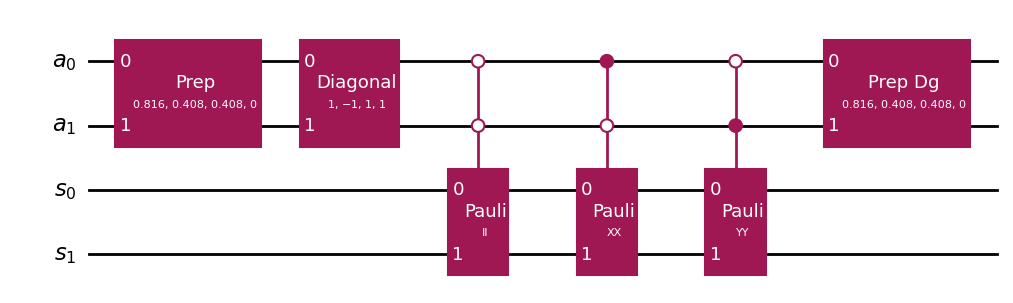

In [ ]:
# 1. Define A and |psi>
A = np.array([
    [1, 0, 0, -0.5],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [-0.5, 0, 0, 1]
], dtype=float)

x = np.array([0.6, 0.8, 0, 0], dtype=complex)
expected_output = A @ x

# 2. Pauli decomposition
pauli_split = SparsePauliOp.from_operator(A)
coeffs = pauli_split.coeffs  # keep complex in general
alpha = np.sum(np.abs(coeffs))

L = len(coeffs)
num_ancilla = int(np.ceil(np.log2(L)))
num_system = int(np.ceil(np.log2(A.shape[0])))

qr_anc = QuantumRegister(num_ancilla, 'a')
qr_sys = QuantumRegister(num_system, 's')
qc = QuantumCircuit(qr_anc, qr_sys)

# PREP
prep_vec = np.pad(np.sqrt(np.abs(coeffs) / alpha), (0, 2**num_ancilla - L))
qc.append(StatePreparation(prep_vec, label = 'Prep'), qr_anc)

# diagonal entries e^{i arg(c_i)} for used i, and 1 for padded states
diag = np.ones(2**num_ancilla, dtype=complex)
diag[:L] = np.exp(1j * np.angle(coeffs))
qc.append(DiagonalGate(diag), qr_anc)

# SELECT (controlled Paulis)
for i, pauli in enumerate(pauli_split.paulis):
    ctrl_gate = pauli.to_instruction().control(
        num_ancilla,
        ctrl_state=format(i, f'0{num_ancilla}b')
    )
    qc.append(ctrl_gate, [*qr_anc, *qr_sys])

# UNPREP
qc.append(StatePreparation(prep_vec, label = 'Prep').inverse(), qr_anc)

# 4. Simulate
full_initial_state = Statevector.from_label('0' * num_ancilla).expand(Statevector(x))
final_statevector = full_initial_state.evolve(qc)


stride = 2**num_ancilla
ancilla_zero_subspace = final_statevector.data[0::stride]   # length = 2**num_system
res_vector = ancilla_zero_subspace * alpha

print("Circuit:", np.round(np.real_if_close(res_vector), 2))
print("Classical:", np.real_if_close(expected_output))

display(qc.draw('mpl'))
